In [145]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.physical_models import BlackBody
import astropy.units as u
import astropy.constants as const


environments = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
                NLTE.NLTE_model.Environment(T_phot= 3350, photosphere_velocity= 0.220, line_velocity= 0.220, t_d=2.42),
                NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.190, line_velocity= 0.190, t_d=3.41),
                NLTE.NLTE_model.Environment(T_phot= 2600, photosphere_velocity= 0.155, line_velocity= 0.155, t_d=4.40),]

                
#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Time scales of reaching equilibruim

[<NLTE.NLTE_model.CollisionProcess object at 0x7f6f3510fdf0>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6f34753f70>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f6f48ad1600>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6f34290d60>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6f3479ca30>]
[<NLTE.NLTE_model.CollisionProcess object at 0x7f6f3476bf40>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6f3476a2f0>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f6f490f9bd0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6f3456d570>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6f3456db70>]


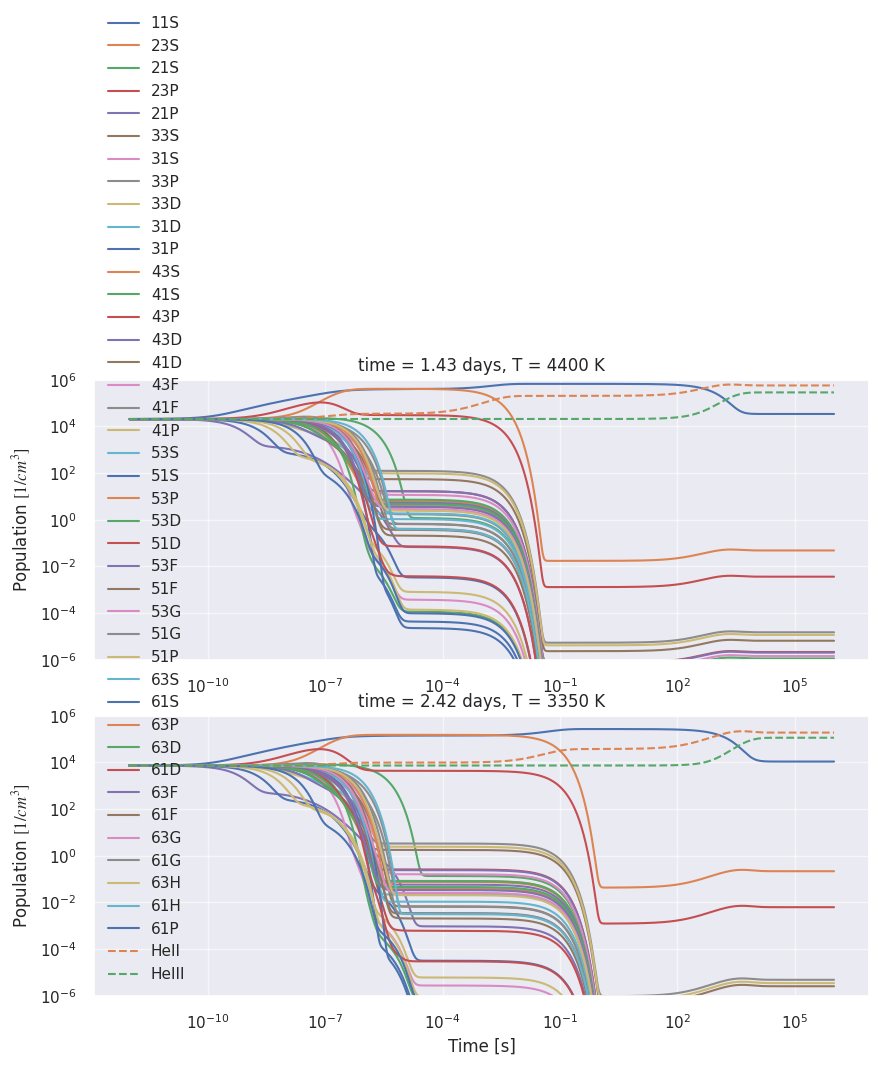

In [150]:
fig, axes = plt.subplots(2, 1, figsize=(10,8))
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 6)
for environment, ax in zip(environments, axes):
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
    print(nlte_solver.processes)
    t, y = nlte_solver.solve(np.geomspace(1e-12,1000000, 1000))
    ax.plot(t, y.T[:, :-2], label = states.names);
    ax.plot(t, y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"]);
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel(r"Population $[1/cm^3]$")
    ax.set_ylim(1e-6, 1e6)
    ax.set_title(f"time = {environment.t_d} days, T = {environment.T_phot} K")
ax.legend(loc="lower left")
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)
ax.set_xlabel("Time [s]")
plt.savefig("plots/time_evolution.png", dpi=300, bbox_inches="tight")

# LTE vs n-level NLTE model level populations

Max fluxes out of ortho for t_d=1.43 and n$\leq$1 (n_23S=0.3599288116386269):
Photoionization          : 23S  -> HeII. Flux: 1.24e+01
Collision                : 23S  -> 21S . Flux: 5.85e-01
Collision                : 23S  -> 11S . Flux: 1.06e-01
Collision                : 23S  -> 21P . Flux: 3.13e-02
Radiative                : 23S  -> 21P . Flux: 6.66e-03
Max fluxes out of ortho for t_d=1.43 and n$\leq$2 (n_23S=0.2099756392726518):
Photoionization          : 23P  -> HeII. Flux: 1.65e+01
Photoionization          : 23S  -> HeII. Flux: 7.24e+00
Radiative                : 23P  -> 11S . Flux: 1.05e+00
Collision                : 23S  -> 21S . Flux: 3.41e-01
Collision                : 23S  -> 11S . Flux: 6.16e-02
Max fluxes out of ortho for t_d=1.43 and n$\leq$3 (n_23S=0.07997436540596031):
Collision                : 33D  -> 31D . Flux: 1.21e+01
Photoionization          : 23P  -> HeII. Flux: 6.31e+00
Photoionization          : 23S  -> HeII. Flux: 2.76e+00
Photoionization          : 33P  -> He

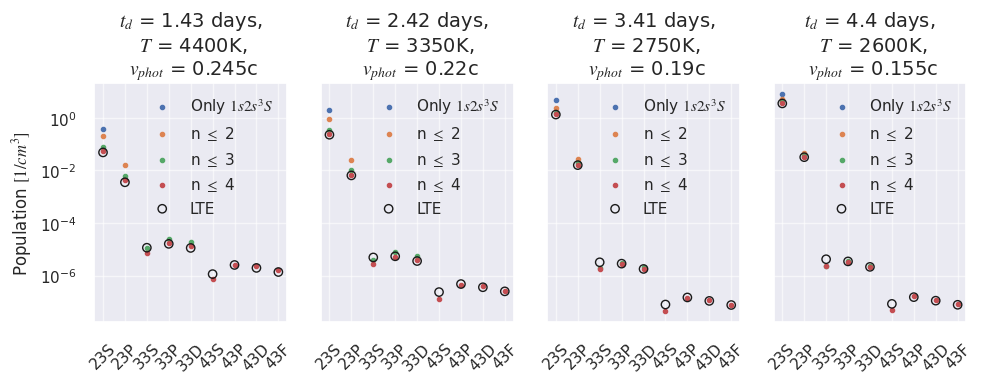

In [153]:
fig, axes = plt.subplots(1, 4, figsize=(10,4), sharey=True)
for environment, ax in zip(environments, axes):
    for max_n in [1,2,3,4]:
        if max_n == 1:
            states = NLTE.NLTE_model.States.read_states(filter = lambda table: (table.index != "23P") & (table["n"] <= 2))
        else:
            states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= max_n)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
        #nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
        y = nlte_solver.solve(1e6)[1][:,-1]
        ortho_filter = np.array([name[-2] == "3" for name in states.all_names])
        ax.scatter(np.array(states.all_names)[ortho_filter], y[ortho_filter], marker=".", label = f"n $\leq$ {max_n}" if max_n > 1 else "Only $1s2s^3S$");

        i = 0
        all_fluxes = [(process.get_transition_rate_matrix() * y[None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)

        print(f"Max fluxes out of ortho for t_d={environment.t_d} and n$\leq${max_n} (n_23S={y[1]}):")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > 5:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
    
    bolzman = states.multiplicities * np.exp(-states.energies / (const.k_B * environment.T_phot * u.K))
    lte_pop = bolzman[ortho_filter[:-2]] / np.sum(bolzman[ortho_filter[:-2]]) * y[1]
    ax.scatter(np.array(states.all_names)[ortho_filter], lte_pop / [1,2,2,2,4,2,2,4,8], marker="o", facecolors='none', edgecolor="k", label = f"LTE");

    ax.set_yscale("log")
    ax.legend()
    
    #ax.set_ylim(1e-2, 1e4)
    ax.set_title(f"$t_d$ = {environment.t_d} days,\n $T$ = {environment.T_phot}K,\n $v_{{phot}}$ = {environment.photosphere_velocity}c", fontsize=14)
    
    #ax.set_xlabel("Time [s]")
    
    ax.set_xticks(np.arange(sum(ortho_filter)))
    ax.set_xticklabels(np.array(states.all_names)[ortho_filter], rotation=45)
axes[0].set_ylabel(r"Population $[1/cm^3]$")
plt.tight_layout()

# Radial 3s3 popolation

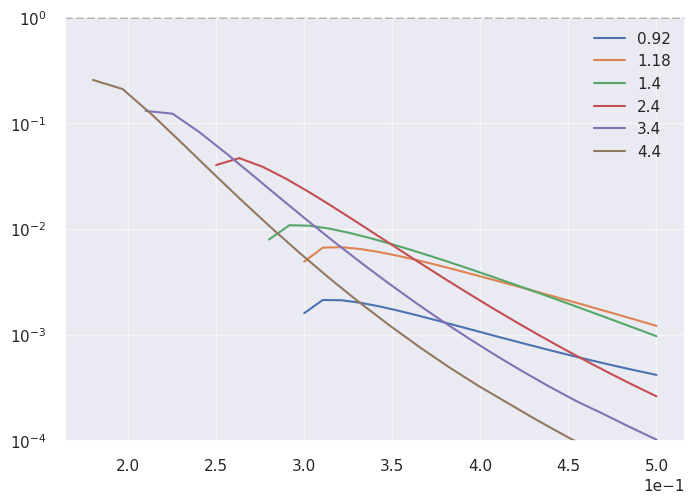

In [154]:

parameters = [{"T_phot": 5400, "photosphere_velocity": 0.3, "t_d": 0.92},
              {"T_phot": 4400, "photosphere_velocity": 0.3, "t_d": 1.18},
              {"T_phot": 4200, "photosphere_velocity": 0.28, "t_d": 1.4},
              {"T_phot": 3300, "photosphere_velocity": 0.25, "t_d": 2.4},
              {"T_phot": 3000, "photosphere_velocity": 0.21, "t_d": 3.4},
              {"T_phot": 2900, "photosphere_velocity": 0.18, "t_d": 4.4},
              ]
density_table = []
for params in parameters:
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 20)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    plt.plot(velocities, densities[:,1]/(7.4*params["t_d"]**-1), label = params["t_d"]);
    plt.yscale("log")
    plt.axhline(1, linestyle="--", color="black")
    #plt.xscale("log")
    plt.ylim(1e-4, 1e0)
    plt.legend()
    plt.grid()
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)

# Comparison with Tarumi et al

 '51S' '53D' '53F' '53G' '53P' '53S' '61D' '61F' '61G' '61H' '61P' '61S'
 '63D' '63F' '63G' '63H' '63P' '63S' '71D' '71F' '71G' '71H' '71I' '71P'
 '71S' '73D' '73F' '73G' '73H' '73I' '73P' '73S']
Inserting ones for missing states
1.925474954211632e-06
Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 1.15e+01
Radiative                : 43F  -> 31D . Flux: 7.05e+00
Radiative                : 33D  -> 41F . Flux: 4.34e+00
Radiative                : 53F  -> 31D . Flux: 8.69e-01
Radiative                : 53F  -> 41D . Flux: 6.70e-01
Radiative                : 33D  -> 51F . Flux: 4.72e-01
Radiative                : 43D  -> 51F . Flux: 4.50e-01
1.4907129162363108e-06
Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 7.06e+00
Radiative                : 43F  -> 31D . Flux: 4.39e+00
Photoionization          : 23P  -> HeII. Flux: 3.69e+00
Radiative                : 33D  -> 41F . Flux: 2.67e+00
Photoionization          : 23S  -> HeII. Flux: 1.61e+00
Pho

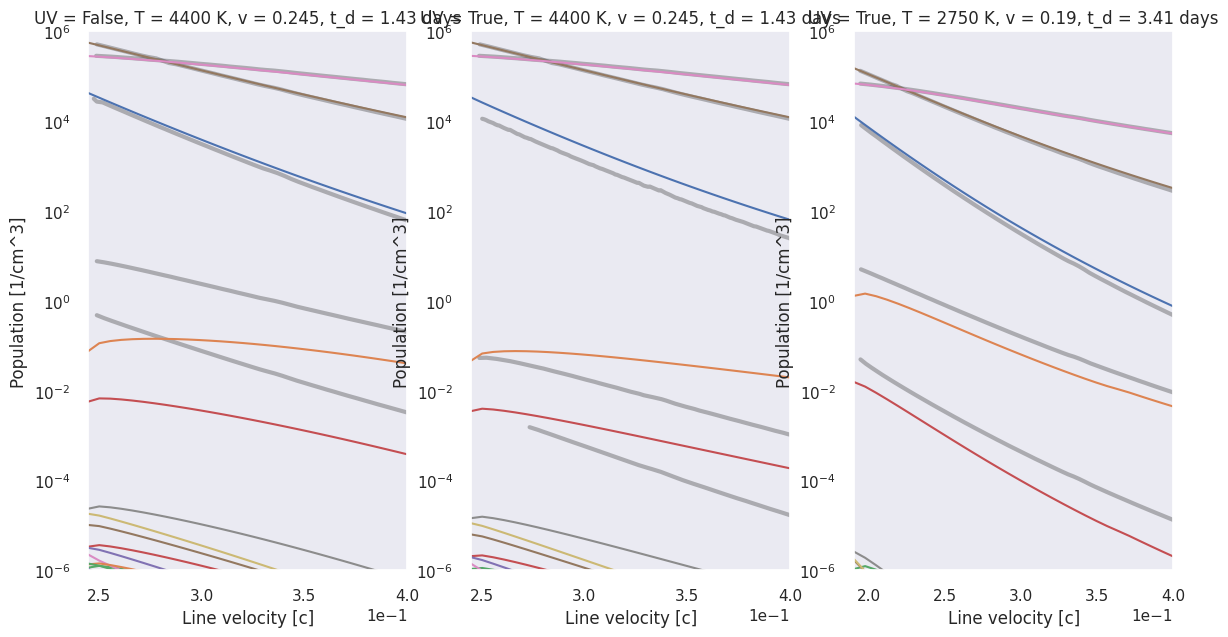

In [155]:
def plot_tarumi(ax, uv, T_phot, photosphere_velocity, t_d, states, print_exits = False):
    velocities = np.linspace(photosphere_velocity, 0.4, 30)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(T_phot= T_phot, photosphere_velocity= photosphere_velocity, line_velocity= v, t_d=t_d)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
        if not uv:
            nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
        
        rad_process = nlte_solver.processes[1]
        coll_process = nlte_solver.processes[0]
        idx_of = lambda x: nlte_solver.states.all_names.index(x)
        for a in []:#"23S", "23P", "33S", "33P", "33D", "43S", "43P", "43D", "43F"]:
            for b in ["11S", "21S", "21P", "31S", "31P", "31D", "41S", "41P", "41D", "41F"]:
                if a == "23S" and b == "11S":
                    continue
                if a in nlte_solver.states.all_names and b in nlte_solver.states.all_names:
                    idx_a = idx_of(a)
                    idx_b = idx_of(b)
                    rad_process.A[idx_b, idx_a] = 0
                    rad_process.A[idx_a, idx_b] = 0
                    rad_process.A[idx_b, idx_a] = 0
                    rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
                    rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
                    rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
                    rad_process.stimulated_emission_rate[idx_b, idx_a] = 0
                    if a == "23S":
                         continue
                    coll_process.collision_rates[idx_a, idx_b] = 0
                    coll_process.collision_rates[idx_b, idx_a] = 0
        #nlte_solver.processes[2].ionization_rates[2:] = 0
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
        

        if print_exits and v == velocities[0]:
            t, y = nlte_solver.solve(1e6)
            all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
            all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
            max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
            ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
            print_count = 7
            i = 0
            print(sum(y[ortho_filter,-1])/y[0,-1])
            print("Max fluxes out of ortho:")
            for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                    #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                    if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                            i += 1
                            if i > print_count:
                                    break
                            print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        
    for name, amount in zip(states.all_names, np.array(densities).T):
        ax.plot(velocities, amount, label=name)

fig, axes = plt.subplots(1, 3, figsize=(14,7))
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 7)
tarumi_state_arr = [["11S", "23P", "23S", "He+", "He2+"], ["11Swithout", "23Pwithout", "23Swithout", "He+", "He2+"], ["11S", "23P", "23S", "He+", "He2+"]]
for ax, uv, T_phot, photosphere_velocity, t_d, tarumi_states in zip(axes, [False, True, True], [4400, 4400, 2750], [0.245, 0.245, 0.190], [1.43, 1.43, 3.41], tarumi_state_arr):
    for name in tarumi_states:
        velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/{'Early' if t_d < 3 else 'Late'}{name}.csv", unpack=True, delimiter=";")
        ax.plot(velocity_23S, pops_23S, label=name, alpha=0.3, linewidth=3, color="k")
    plot_tarumi(ax, uv, T_phot, photosphere_velocity, t_d, states, print_exits = True)
    ax.set_title(f"UV = {uv}, T = {T_phot} K, v = {photosphere_velocity}, t_d = {t_d} days")
    ax.set_xlabel("Line velocity [c]")
    ax.set_ylabel("Population [1/cm^3]")
    ax.grid()
    ax.set_yscale("log")
    #ax.legend()
    ax.set_ylim(1e-6, 1e6)
    ax.set_xlim(photosphere_velocity, 0.4)

Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 8.38e+00
Radiative                : 43F  -> 31D . Flux: 5.09e+00
Photoionization          : 23P  -> HeII. Flux: 4.39e+00
Radiative                : 33D  -> 41F . Flux: 3.18e+00
Photoionization          : 23S  -> HeII. Flux: 1.92e+00
Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 6.13e+00
Photoionization          : 23P  -> HeII. Flux: 3.50e+00
Radiative                : 43F  -> 31D . Flux: 3.22e+00
Radiative                : 33D  -> 41F . Flux: 2.00e+00
Photoionization          : 23S  -> HeII. Flux: 1.97e+00
Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 4.36e+00
Photoionization          : 23P  -> HeII. Flux: 2.71e+00
Radiative                : 43F  -> 31D . Flux: 2.25e+00
Photoionization          : 23S  -> HeII. Flux: 1.72e+00
Radiative                : 33D  -> 41F . Flux: 1.40e+00
Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 3.09e+00
Phot

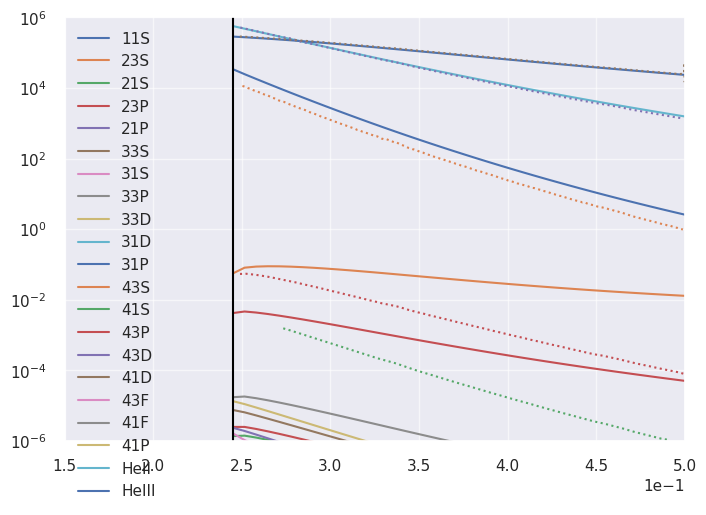

In [156]:
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
velocities = np.linspace(0.245, 0.5, 40)
densities = []
for v in velocities:
    environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= v, t_d=1.43)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
    
    rad_process = nlte_solver.processes[1]
    idx_of = lambda x: nlte_solver.states.all_names.index(x)

    for a,b in [("23P", "11S"), ("23P", "21S"), ("23P", "21P"), ("23P", "21S"), ("23S", "21S"), ("23S", "21P") ]:
        idx_a = idx_of(a)
        idx_b = idx_of(b)
        rad_process.A[idx_a, idx_b] = 0
        rad_process.A[idx_b, idx_a] = 0
        rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
        rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
        rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
        rad_process.stimulated_emission_rate[idx_b, idx_a] = 0
    #nlte_solver.processes[2].ionization_rates[2:] = 0
    densities.append(nlte_solver.solve(1e7)[1][:, -1])
    

    t, y = nlte_solver.solve(1e6)
    all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
    all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
    max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
    ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
    print_count = 5
    i = 0
    print("Max fluxes out of ortho:")
    for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
            #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
            if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                    i += 1
                    if i > print_count:
                            break
                    print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")


    
for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)


tarumi_states = ["11Swithout", "23Pwithout", "23Swithout", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/Early{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=1, linestyle=":")
plt.xlim(0.15, 0.5)
plt.axvline(0.245, linestyle="-", color="black")

Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 1.16e+00
Radiative                : 43F  -> 31D . Flux: 4.12e-01
Collision                : 23S  -> 21S . Flux: 3.75e-01
Radiative                : 33D  -> 41F . Flux: 2.56e-01
Collision                : 23S  -> 11S . Flux: 2.52e-01
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 1.18e-01
Collision                : 23S  -> 11S . Flux: 9.09e-02
Collision                : 33D  -> 31D . Flux: 5.26e-02
Radiative                : 43F  -> 31D . Flux: 1.84e-02
Radiative                : 33D  -> 41F . Flux: 1.08e-02
Max fluxes out of ortho:
Collision                : 23S  -> 21S . Flux: 1.97e-02
Collision                : 23S  -> 11S . Flux: 1.74e-02
Collision                : 33D  -> 31D . Flux: 2.75e-03
Radiative                : 43F  -> 31D . Flux: 1.29e-03
Radiative                : 33D  -> 41F . Flux: 6.84e-04
Max fluxes out of ortho:
Collision                : 23S  -> 11S . Flux: 3.41e-03
Coll

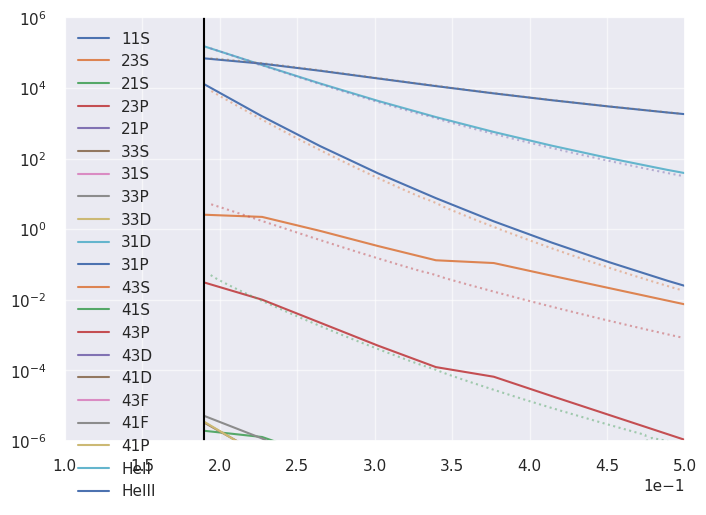

In [157]:
states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 4)
velocities = np.linspace(0.19, 0.9, 20)
densities = []
for v in velocities:
    #states = NLTE.NLTE_model.States().filter(["11S", "23S", "21S", "23P", "21P", "33S"])
    environment  = NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.19, line_velocity= v, t_d= 3.41)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    
    rad_process = nlte_solver.processes[1]
    idx_of = lambda x: nlte_solver.states.all_names.index(x)

    for a,b in [("23P", "11S"), ("23P", "21S"), ("23P", "21P"), ("23P", "21S"), ("23S", "21S"), ("23S", "21P") ]:
        idx_a = idx_of(a)
        idx_b = idx_of(b)
        rad_process.A[idx_a, idx_b] = 0
        rad_process.A[idx_b, idx_a] = 0
        rad_process.arbsorbtion_rate[idx_a, idx_b] = 0
        rad_process.arbsorbtion_rate[idx_b, idx_a] = 0
        rad_process.stimulated_emission_rate[idx_a, idx_b] = 0
        rad_process.stimulated_emission_rate[idx_b, idx_a] = 0
    densities.append(nlte_solver.solve(1e7)[1][:, -1])


    t, y = nlte_solver.solve(1e6)
    all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
    all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
    max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
    ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
    print_count = 5
    i = 0
    print("Max fluxes out of ortho:")
    for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
            #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
            if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                    i += 1
                    if i > print_count:
                            break
                    print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")



for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)

tarumi_states = ["11S", "23P", "23S", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/late{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.1, 0.5)
plt.axvline(0.19, linestyle="-", color="black")

In [158]:

nlte_solver.processes

[<NLTE.NLTE_model.CollisionProcess object at 0x7f6f33978520>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6f33864ac0>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f6f33867c70>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6f33865060>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6f33867520>]
[<NLTE.NLTE_model.CollisionProcess object at 0x7f6f33865720>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6f33864f10>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f6f33864fd0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6f338665c0>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6f33867640>]
[<NLTE.NLTE_model.CollisionProcess object at 0x7f6f33a96bf0>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f6f33a94070>, <NLTE.NLTE_model.PhotoionizationProcess object at 0x7f6f33a9f5e0>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f6f33a96ad0>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f6f33866590>]
[<NLTE.NLTE_mode

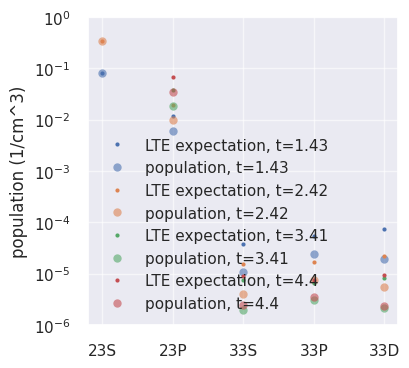

In [159]:

fig, ax1 = plt.subplots(1,1, figsize=(4,4))
for i, environment in enumerate(environments):
    nlte_solver = NLTE.NLTE_model.NLTESolver( environment)
    nlte_solver.processes = nlte_solver.processes
    t, y = nlte_solver.solve(1e6)
    print(nlte_solver.processes)
    ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
    names = np.array(nlte_solver.states.all_names)[ortho_filter]
    ax1_left  = ax1
    p_i = nlte_solver.states.multiplicities * np.exp(-nlte_solver.states.energies / (const.k_B * nlte_solver.environment.T_electrons*u.K))
    p_i = p_i * y[1, -1] / p_i[1]
    ax1_left.plot(names,  p_i[ortho_filter[:-2]], ".", alpha=1, label=f"LTE expectation, t={environment.t_d}", color=f"C{i}")
    ax1_left.semilogy(names, y[ortho_filter, -1], "o", alpha=0.6, label=f"population, t={environment.t_d}", color=f"C{i}")
    ax1_left.legend(loc="lower left")
    ax1_left.set_ylim(1e-6, 1e0)
    ax1_left.set_ylabel("population (1/cm^3)")
plt.savefig("plots/ortho_population.png", dpi=300, bbox_inches="tight")


Max flux:
Radiative                : 23P  -> 23S . Flux: 6.30e+04
Radiative                : 23S  -> 23P . Flux: 6.30e+04
Radiative                : 23P  -> 33D . Flux: 2.37e+03
Radiative                : 33D  -> 23P . Flux: 2.36e+03
Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 1.21e+01
Photoionization          : 23P  -> HeII. Flux: 6.31e+00
Photoionization          : 23S  -> HeII. Flux: 2.76e+00
Photoionization          : 33P  -> HeII. Flux: 1.93e+00
Photoionization          : 33D  -> HeII. Flux: 8.63e-01
Radiative                : 23P  -> 11S . Flux: 3.99e-01
Radiative                : 33D  -> 21P . Flux: 2.91e-01
Photoionization          : 33S  -> HeII. Flux: 1.83e-01
Collision                : 23S  -> 21S . Flux: 1.30e-01
Radiative                : 23P  -> 31D . Flux: 1.07e-01
Collision                : 23S  -> 11S . Flux: 2.35e-02
Collision                : 23P  -> 21P . Flux: 1.66e-02
Collision                : 23P  -> 21S . Flux: 1.42e-02
Collision    

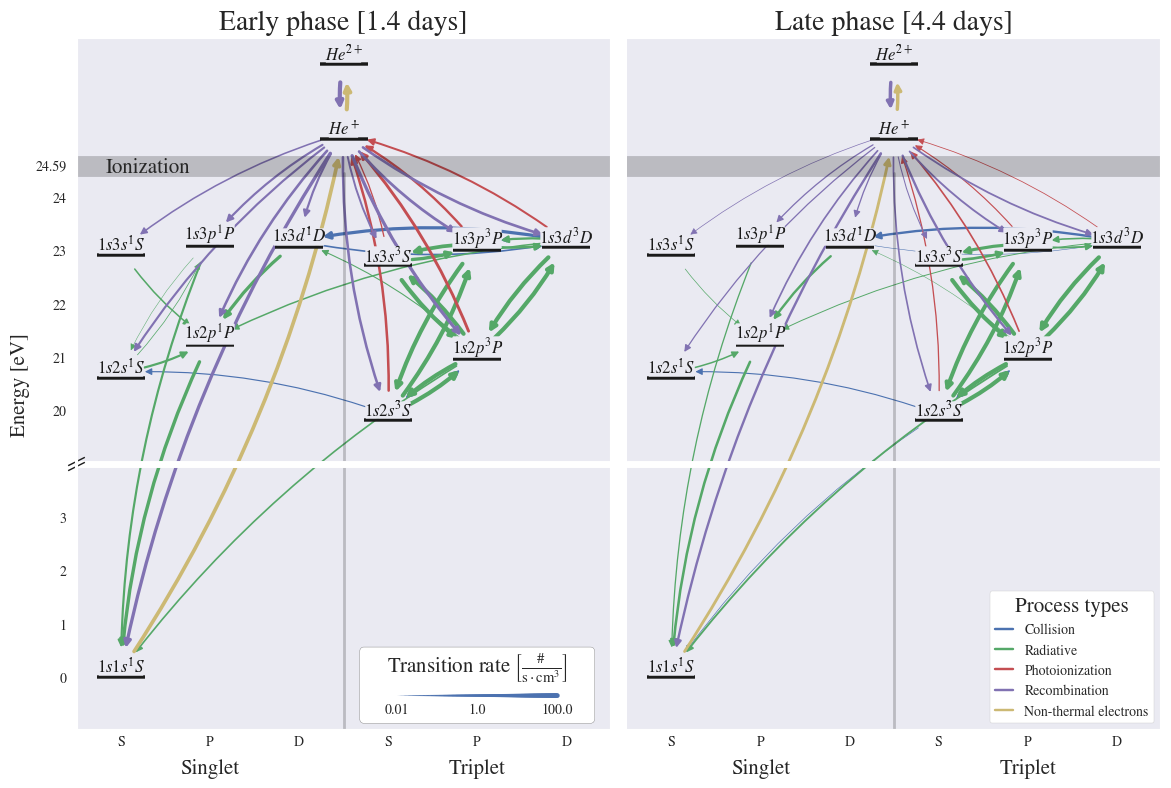

In [160]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')


#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize, titlesize=None):
    if titlesize is None:
        titlesize = fontsize
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['legend.fontsize'] = ticksize
    plt.rcParams['legend.title_fontsize'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['figure.facecolor'] = 'white'
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
reset_plt(10,15, 20)

print_count = 15

# A_{i,j} = rate to state i from state j 
#environments  = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
#                 NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43)]
fig, axes = plt.subplots(1, 2, sharey="row", figsize=(14,9), facecolor="white")
plt.subplots_adjust( wspace=0.03)
min_rate = 0.01
max_rate = 1e2
max_width = 3

for environment, ax, title in zip(environments, axes, ["Early phase [1.4 days]", "Late phase [4.4 days]"]):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        states = NLTE.NLTE_model.States.read_states(filter = lambda table: table["n"] <= 3)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states)
        nlte_solver.processes = nlte_solver.processes
        states = nlte_solver.states
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        print("Max flux:")
        ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])

        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
                i += 1
                if i > 3:
                        break
        i = 0
        print("Max fluxes out of ortho:")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                widths = np.interp(np.log10(np.maximum(process_fluxes, min_rate)), np.log10([min_rate, max_rate]), [0, max_width])
                widths = widths * (widths >= 0.3)
                        #np.log10([min_rate, max_rate]), [0, max_width], np.log10(process_fluxes)
                #widths = np.clip(np.log10(process_fluxes/max_flux)+dynamic_range, 0, 10)/dynamic_range*3
                #widths = np.clip(process_fluxes/max_flux * 5, 0, 10)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                x_pos = {"11S": 0,  "21S": 0,   "31S": 0,
                                    "21P": 1,   "31P": 1, 
                                                "31D": 2, 
                                    "23S": 3,   "33S": 3,
                                    "23P": 4,   "33P": 4, 
                                                "33D": 5, 
                       }
                final_pos = {name: (x_pos[name], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (2.5, 25.1) # add HeII and HeIII
                final_pos["HeIII"] = (2.5, 26.5)
                final_pos["11S"] = 0, 15      # modify 11S
                labels = {name: f"$1s{name[0]}{name[2].lower()}^{name[1]}{name[2]}$" for name in nlte_solver.states.names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                #nx.draw(G, final_pos, ax=ax,
                #        width=list(weights), edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                #        with_labels=True, labels=labels, 
                #        node_color='k', node_shape="_", node_size=1200, font_size=10, font_weight="light", 
                #        verticalalignment="bottom", 
                #        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
                nx.draw_networkx_edges(G, {name: np.array([0,0.1])+final_pos[name] for name in final_pos}, ax=ax, width=list(weights), edge_color=f'C{i}', node_size=1200 ,connectionstyle="arc3,rad=0.1",)
                nx.draw_networkx_nodes(G, final_pos, ax=ax, node_color='k', node_shape="_", node_size=1200)
                nx.draw_networkx_labels(G, final_pos, ax=ax, labels=labels, font_weight="light", verticalalignment="bottom",
                                        bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))
                ax.plot([],[], color=f'C{i}', label=f'{process.name}')
        ax.set_ylim(14, 27)
        ax.plot([2.5, 2.5], [0,24.45], linestyle="-", linewidth=2, alpha=0.2, color="black")
        
        ax.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        ax.set_xlim(-0.5, 5.5)
        ax.set_ylim(14, 27)

        ax.axis("on")

        ax.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2, final_pos["11S"][1]+3, 19, 20, 21, 22, 23, 24, 24.59])
        ax.set_yticklabels([str(x - 15 if x < 20 else x).removesuffix(".0") if x != 19 else "" for x in ax.get_yticks()])


        ax.tick_params(axis='x', which='major', pad=20)
        ax.set_xticks([1.001, 3.999])
        ax.set_xticklabels(["Singlet", "Triplet"], fontsize=15)
        ax.minorticks_on()
        ax.set_xticks([0, 1, 2, 3, 4, 5], minor=True)

        ax.set_xticklabels(["S", "P", "D", "S", "P", "D"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)
        ax.set_title(title)
        ax.grid()

ax.legend(loc="lower right", title="Process types", handlelength=1.3, facecolor="white", framealpha=1, frameon=True)

# make width scale
axes[0].scatter(np.linspace(0.6,0.9, 200),np.zeros(200)+0.05, s=np.linspace(0, max_width, 200)**2, alpha=1 , transform=axes[0].transAxes)
axes[0].text(0.6, 0.03, str(min_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.03, str(round((min_rate*max_rate)**0.5,3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.9, 0.03, str(max_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.09, r"Transition rate $\left[\frac{\text{#}}{\text{s}\cdot \text{cm}^3}\right]$", transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.title_fontsize'])
# draw white box containing the above scale, with rounded corners
axes[0].add_patch(matplotlib.patches.FancyBboxPatch((0.55, 0.03), 0.4, 0.07, transform=axes[0].transAxes, boxstyle="round,rounding_size=0.008,pad=0.02", fc="white", ec="gray", zorder=0))
        
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
        linestyle="none", color='k', mec='k', mew=1, clip_on=False)

axes[0].set_ylabel("Energy [eV]")
axes[0].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[1].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[0].axhline(19, linestyle="-", linewidth=5, color="white")
axes[1].axhline(19, linestyle="-", linewidth=5, color="white")
axes[0].text(0.3, 24.55, "Ionization", ha="center", va="center")
axes[0].plot([-0.5], [19+0.05], **kwargs)
axes[0].plot([-0.5], [19-0.05], **kwargs)
axes[1].tick_params(left=False, labelleft=False, which="both")
axes[1].spines.left.set_visible(False)
plt.savefig(f"plots/transition_rates.png", bbox_inches="tight", dpi=300)

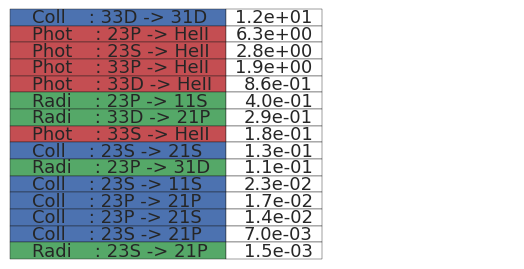

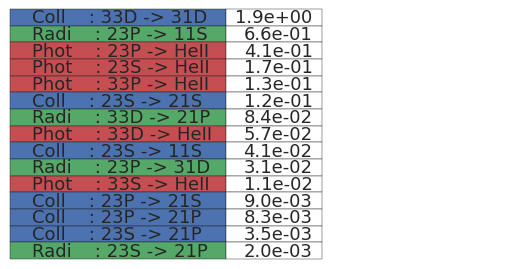

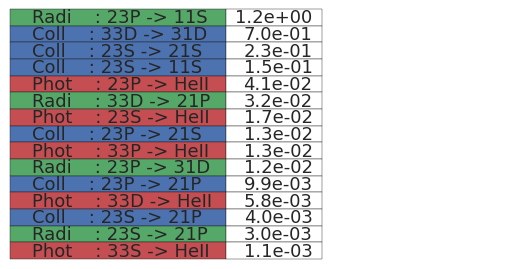

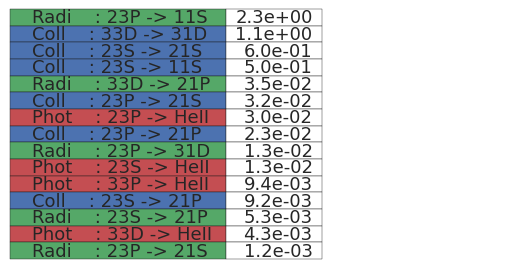

In [161]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')

print_count = 15
ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])
for environment,  in zip(environments):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        table = []
        labels = []
        colors = []
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        labels.append(f"{nlte_solver.processes[process_idx].name[:4]:8s}: {states.all_names[origin_idx]} -> {states.all_names[destination_idx]}")
                        table.append([f"{all_fluxes[process_idx, destination_idx, origin_idx]:1.1e}"])
                        colors.append(f"C{process_idx}")
        plt.figure(figsize=(6,4))
        plt.grid()
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.4, top=1)
        plt.axis("off")
        the_table = plt.table(cellText=table, rowColours=colors, rowLabels=labels, loc='center', colWidths=[0.2, 0.2, 0.2, 0.2])
        plt.savefig(f"plots/transition_rates_{title}.png", bbox_inches="tight", dpi=300)

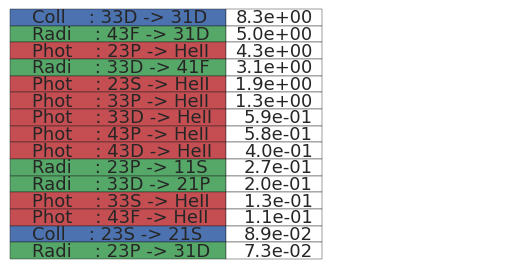

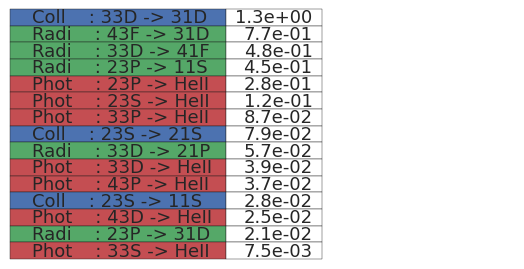

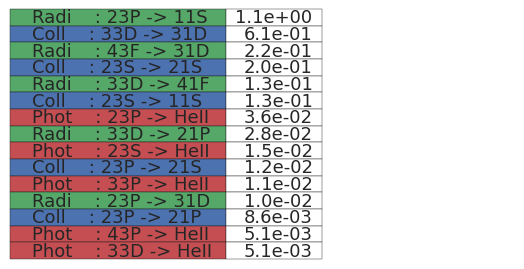

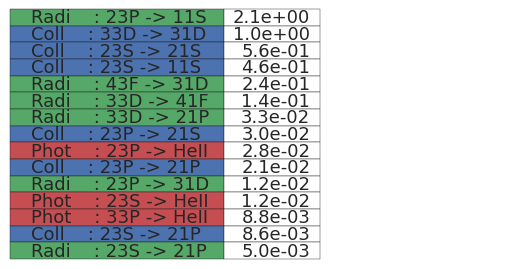

In [162]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')

environments_UV = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
                   NLTE.NLTE_model.Environment(T_phot= 3350, photosphere_velocity= 0.220, line_velocity= 0.220, t_d=2.42),
                   NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.190, line_velocity= 0.190, t_d=3.41),
                   NLTE.NLTE_model.Environment(T_phot= 2600, photosphere_velocity= 0.155, line_velocity= 0.155, t_d=4.40),]

states = NLTE.NLTE_model.States.read_states()
ortho_filter = np.array([x[1] == "3" for x in states.all_names])
print_count = 15
for environment,  in zip(environments_UV):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        table = []
        labels = []
        colors = []
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        labels.append(f"{nlte_solver.processes[process_idx].name[:4]:8s}: {states.all_names[origin_idx]} -> {states.all_names[destination_idx]}")
                        table.append([f"{all_fluxes[process_idx, destination_idx, origin_idx]:1.1e}"])
                        colors.append(f"C{process_idx}")
        plt.figure(figsize=(6,4))
        plt.grid()
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.4, top=1)
        plt.axis("off")
        the_table = plt.table(cellText=table, rowColours=colors, rowLabels=labels, loc='center', colWidths=[0.2, 0.2, 0.2, 0.2])
        plt.savefig(f"plots/transition_rates_{environment.t_d}.png", bbox_inches="tight", dpi=300)

/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


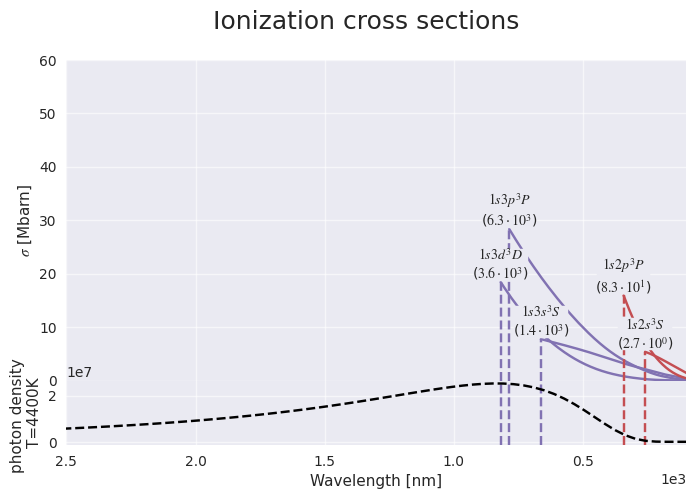

In [163]:
import NLTE.NLTE_model
ionization_rates = []
ionization_dict = NLTE.NLTE_model.get_ionization_dict()
spectrum = NLTE.NLTE_model.Environment().spectrum
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,5), sharex=True, height_ratios=[5, 1])
fancy_names = NLTE.NLTE_model.States().get_fancy_names()
format_latex_exponential = lambda x: f"${x:.1e}}}$".replace("e-0", "\cdot10^{-").replace("e+0", "\cdot10{^").replace("e+","\cdot10{^").replace("e-","\cdot10^{-")

for state in reversed(sorted(ionization_dict.keys())):
    if not (state[0] in "123" and state[1] == "3"):
        continue
    energies, crossection = ionization_dict[state]
    E = (energies * u.Ry).cgs
    nu = E.to(u.Hz, equivalencies=u.spectral()) 
    sigma = (crossection * u.Mbarn).cgs
    ionization_flux_article = u.sr * sigma
    x = E.to("nm", equivalencies=u.spectral()).value
    ax1.plot(x, crossection, label=state, color=f"C{state[0]}") 
    ax1.plot([x[0],x[0]], [0,crossection[0]], linestyle="--", color=f"C{state[0]}")
    ax2.axvline(x[[0]], linestyle="--", color=f"C{state[0]}")

    g = ("SPDFA".index(state[2])) *2 + 1
    lte_pop = g * np.exp(-(-E[0] + 0.3503019 * u.Ry)/(const.k_B*4400*u.K))
    ionization_flux_article = u.sr * sigma * (spectrum(nu)/E)
    #print(f"{state},\n R={np.trapz(x=nu, y=ionization_flux_article).to(1/u.s).value},\n LTE pop: {lte_pop.value}")
    ax1.text(x[[0]], crossection[0], f"{fancy_names[state]}\n({format_latex_exponential(np.trapz(x=nu, y=ionization_flux_article).to(1/u.s).value)})", 
             verticalalignment="bottom", horizontalalignment="center", fontsize=10,bbox=dict(facecolor=ax.get_facecolor(), edgecolor = ax.get_facecolor(), boxstyle='square,pad=-0.1'))


nm_range = np.linspace(100, 4000, 100) * u.nm
spectrum = BlackBody(4400 * u.K, scale=2*np.pi*u.Unit("erg/(s nm sr cm2)")) 
ax2.plot(nm_range, spectrum(nm_range)/nm_range.to("eV", equivalencies = u.spectral()), "--", color="black", alpha=1)
#spectrum = BlackBody(4400 * u.K, scale=2*np.pi*u.Unit("erg/(s nm sr cm2)")) 
#ax2.plot(nm_range, spectrum(nm_range)/nm_range.to("eV", equivalencies = u.spectral()), "--", color="black", alpha=1)

ax1.set_ylim(0, 6e1)
ax1.set_xlim(2500, 100)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel("Wavelength [nm]")
ax1.set_ylabel(r"$\sigma$ [Mbarn]")
ax2.set_ylabel("photon density \nT=4400K")
plt.suptitle("Ionization cross sections")
#ax1.yscale("log")
# plot spectrum on right axis
#plt.yscale("log")
#plt.ylim(0, 1e-1)
plt.savefig("plots/ionization_crosssections.png", dpi=300, bbox_inches="tight")

Max flux:
Radiative                : 23P  -> 23S . Flux: 4.33e+04
Radiative                : 23S  -> 23P . Flux: 4.33e+04
Radiative                : 23P  -> 33D . Flux: 1.63e+03
Radiative                : 33D  -> 23P . Flux: 1.62e+03
Max fluxes out of ortho:
Collision                : 33D  -> 31D . Flux: 8.29e+00
Radiative                : 43F  -> 31D . Flux: 5.03e+00
Photoionization          : 23P  -> HeII. Flux: 4.34e+00
Radiative                : 33D  -> 41F . Flux: 3.14e+00
Photoionization          : 23S  -> HeII. Flux: 1.90e+00
Photoionization          : 33P  -> HeII. Flux: 1.34e+00
Photoionization          : 33D  -> HeII. Flux: 5.93e-01
Photoionization          : 43P  -> HeII. Flux: 5.80e-01
Photoionization          : 43D  -> HeII. Flux: 3.95e-01
Radiative                : 23P  -> 11S . Flux: 2.74e-01
Radiative                : 33D  -> 21P . Flux: 2.00e-01
Photoionization          : 33S  -> HeII. Flux: 1.27e-01
Photoionization          : 43F  -> HeII. Flux: 1.12e-01
Collision    

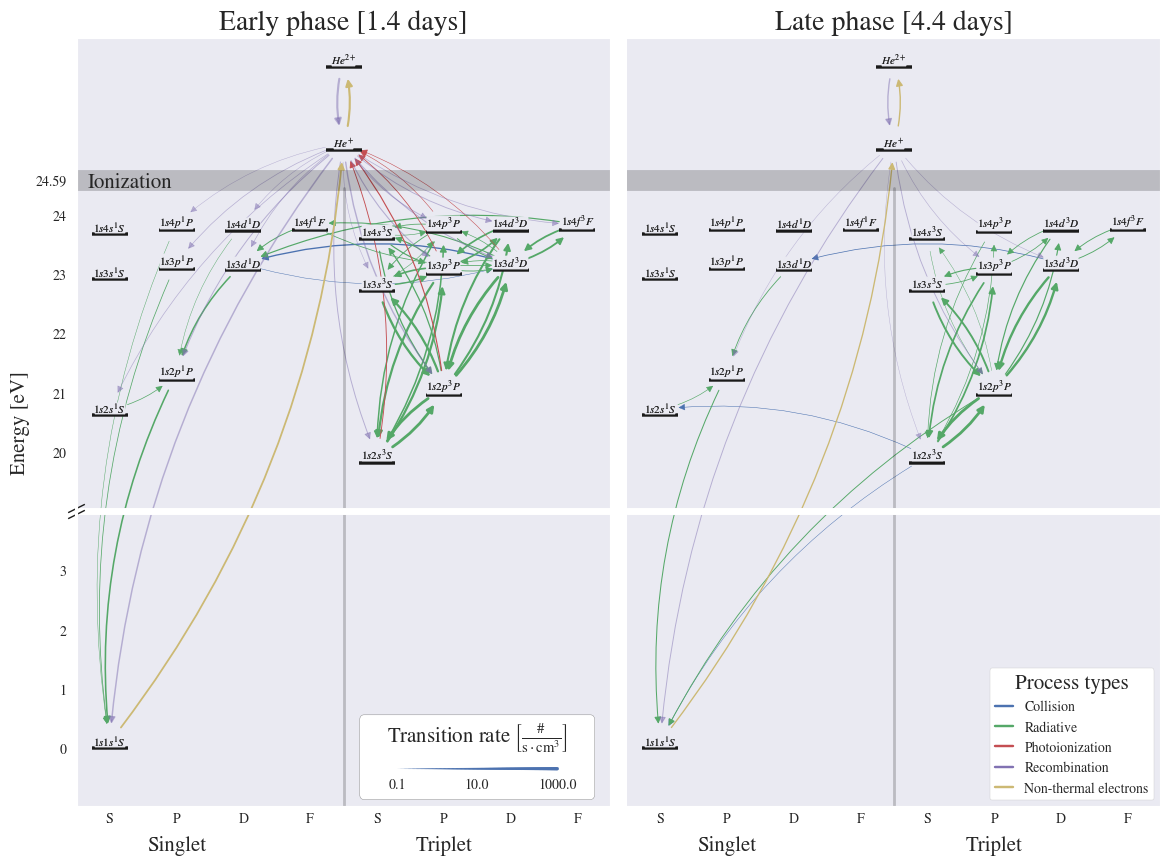

In [164]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')


#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize, titlesize=None):
    if titlesize is None:
        titlesize = fontsize
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['legend.fontsize'] = ticksize
    plt.rcParams['legend.title_fontsize'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['figure.facecolor'] = 'white'
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
reset_plt(10,15, 20)

print_count = 15

# A_{i,j} = rate to state i from state j 
#environments  = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
#                 NLTE.NLTE_model.Environment(T_phot= 2900, photosphere_velocity= 0.19, line_velocity=  0.19, t_d=4.43)]
fig, axes = plt.subplots(1, 2, sharey="row", figsize=(14,10), facecolor="white")
plt.subplots_adjust( wspace=0.03)
min_rate = 0.1
max_rate = 1e3
max_width = 2

for environment, ax, title in zip([environments[0], environments[-1]], axes, ["Early phase [1.4 days]", "Late phase [4.4 days]"]):
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        #fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2.5, 1.5]})
        states = NLTE.NLTE_model.States.read_states(lambda table: table["n"] <= 4)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        all_fluxes = [(process.get_transition_rate_matrix() * y.T[-1][None,:]) for process in nlte_solver.processes]
        all_fluxes = np.array(all_fluxes)#[:,~ortho_filter][:,:, ortho_filter]
        max_index = np.unravel_index(np.argsort(-all_fluxes, axis=None), all_fluxes.shape)
        i = 0
        print("Max flux:")
        ortho_filter = np.array([x[1] == "3" for x in nlte_solver.states.all_names])

        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")
                i += 1
                if i > 3:
                        break
        i = 0
        print("Max fluxes out of ortho:")
        for process_idx, destination_idx, origin_idx in list(zip(*max_index)):
                #if states.all_names[origin_idx] in ["23S", "23P"] and not ortho_filter[destination_idx]:
                if ortho_filter[origin_idx] and not ortho_filter[destination_idx]:
                        i += 1
                        if i > print_count:
                                break
                        print(f"{nlte_solver.processes[process_idx].name:25s}: {states.all_names[origin_idx]:4} -> {states.all_names[destination_idx]:4}. Flux: {all_fluxes[process_idx, destination_idx, origin_idx]:.2e}")

        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]
                widths = np.interp(np.log10(np.maximum(process_fluxes, min_rate)), np.log10([min_rate, max_rate]), [0, max_width])
                widths = widths * (widths >= 0.3)
                G = nx.DiGraph(widths)
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names))}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                x_pos = {"11S": 0,  "21S": 0,   "31S": 0,
                                    "21P": 1,   "31P": 1, 
                                                "31D": 2, 
                                    "23S": 3,   "33S": 3,
                                    "23P": 4,   "33P": 4, 
                                                "33D": 5, 
                       }
                x_pos = {name: "SPDF".index(name[2]) + (4 if name[1] == "3" else 0) for name in states.names}
                final_pos = {name: (x_pos[name], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (3.5, 25.1) # add HeII and HeIII
                final_pos["HeIII"] = (3.5, 26.5)
                final_pos["11S"] = 0, 15      # modify 11S
                labels = {name: f"$1s{name[0]}{name[2].lower()}^{name[1]}{name[2]}$" for name in nlte_solver.states.names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                alpha = 0.5 if process.name == "Recombination" else 1
                nx.draw_networkx_edges(G, {name: np.array([0,0.1])+final_pos[name] for name in final_pos}, ax=ax, width=list(weights), alpha = alpha, edge_color=f'C{i}', node_size=700 ,connectionstyle="arc3,rad=0.15",)
                nx.draw_networkx_nodes(G, final_pos, ax=ax, node_color='k', node_shape="_", node_size=700)
                nx.draw_networkx_labels(G, final_pos, ax=ax, labels=labels, font_weight="light", verticalalignment="bottom",font_size=8,
                                        bbox=dict(facecolor=ax.get_facecolor()*np.array([1,1,1,0.5]), alpha=0.5, edgecolor = ax.get_facecolor()*np.array([1,1,1,0.5]), boxstyle='square,pad=-0.1'))
                ax.plot([],[], color=f'C{i}', label=f'{process.name}')
        ax.set_ylim(14, 27)
        ax.plot([3.5, 3.5], [0,24.45], linestyle="-", linewidth=2, alpha=0.2, color="black")
        
        ax.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        ax.set_xlim(-0.5, 7.5)
        ax.set_ylim(14, 27)

        ax.axis("on")

        ax.set_yticks([final_pos["11S"][1], final_pos["11S"][1]+1, final_pos["11S"][1]+2, final_pos["11S"][1]+3, 19, 20, 21, 22, 23, 24, 24.59])
        ax.set_yticklabels([str(x - 15 if x < 20 else x).removesuffix(".0") if x != 19 else "" for x in ax.get_yticks()])


        ax.tick_params(axis='x', which='major', pad=20)
        ax.set_xticks([1.001, 4.999])
        ax.set_xticklabels(["Singlet", "Triplet"], fontsize=15)
        ax.minorticks_on()
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7], minor=True)

        ax.set_xticklabels(["S", "P", "D", "F", "S", "P", "D", "F"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)
        ax.set_title(title)
        ax.grid()

ax.legend(loc="lower right", title="Process types", handlelength=1.3, facecolor="white", framealpha=1, frameon=True)

# make width scale
axes[0].scatter(np.linspace(0.6,0.9, 200),np.zeros(200)+0.05, s=np.linspace(0, max_width, 200)**2, alpha=1 , transform=axes[0].transAxes)
axes[0].text(0.6, 0.03, str(min_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.03, str(round((min_rate*max_rate)**0.5,3)), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.9, 0.03, str(max_rate), transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.fontsize'])
axes[0].text(0.75, 0.09, r"Transition rate $\left[\frac{\text{#}}{\text{s}\cdot \text{cm}^3}\right]$", transform=axes[0].transAxes, ha="center", va="center", fontsize=plt.rcParams['legend.title_fontsize'])
# draw white box containing the above scale, with rounded corners
axes[0].add_patch(matplotlib.patches.FancyBboxPatch((0.55, 0.03), 0.4, 0.07, transform=axes[0].transAxes, boxstyle="round,rounding_size=0.008,pad=0.02", fc="white", ec="gray", zorder=0))
        
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
        linestyle="none", color='k', mec='k', mew=1, clip_on=False)

axes[0].set_ylabel("Energy [eV]")
axes[0].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[1].axhline(24.59, linestyle="-", linewidth=15, alpha=0.2, color="black")
axes[0].axhline(19, linestyle="-", linewidth=5, color="white")
axes[1].axhline(19, linestyle="-", linewidth=5, color="white")
axes[0].text(0.3, 24.55, "Ionization", ha="center", va="center")
axes[0].plot([-0.5], [19+0.05], **kwargs)
axes[0].plot([-0.5], [19-0.05], **kwargs)
axes[1].tick_params(left=False, labelleft=False, which="both")
axes[1].spines.left.set_visible(False)
plt.savefig(f"plots/transition_rates.png", bbox_inches="tight", dpi=300)

In [172]:
# make pyplot table
import pandas
for environment in [NLTE.NLTE_model.Environment(T_phot= 4900, photosphere_velocity= 0.26, line_velocity= 0.28, t_d=1.17)]+ environments:
    states = NLTE.NLTE_model.States.read_states(lambda table: table["n"] <= 4)
    table = {"states" : states.all_names}
    triplet_filter = np.array([x[1] in "3e"  for x in states.all_names])

    nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states=states)
    t, y = nlte_solver.solve(1e6)
    for process in nlte_solver.processes:
        mat = process.get_transition_rate_matrix()
        #print("epoc: ", environment.t_d, "process: ", process.name)
        #print(1/np.sum(mat, axis=0))

        table[process.name] = 1/np.sum(mat, axis=0)/3600
    df = pandas.DataFrame(table)
    print(f"Environment t_d: {environment.t_d}")
    print(df[triplet_filter])

/tmp/ipykernel_273054/338393275.py:15: RuntimeWarning: divide by zero encountered in divide
  table[process.name] = 1/np.sum(mat, axis=0)/3600


Environment t_d: 1.17
   states     Collision     Radiative  Photoionization  Recombination  \
1     23S  4.811597e-05  4.260307e-10     4.060355e-06            inf   
3     23P  1.133877e-05  2.548465e-11     1.745909e-07            inf   
5     33S  9.804571e-07  9.561022e-12     1.540315e-08            inf   
7     33P  1.391320e-07  2.237055e-11     3.636704e-09            inf   
8     33D  5.361590e-10  2.206438e-12     6.536936e-09            inf   
11    43S  1.697192e-06  1.598984e-11     4.489182e-09            inf   
13    43P  2.594348e-06  3.530186e-11     1.400818e-09            inf   
14    43D  5.468716e-06  5.055190e-12     1.976507e-09            inf   
16    43F  1.504382e-08  9.788763e-12     4.892608e-09            inf   
19   HeII           inf           inf              inf       3.920331   
20  HeIII           inf           inf              inf       0.775317   

    Non-thermal electrons  
1                0.202020  
3                0.202020  
5                

/tmp/ipykernel_273054/338393275.py:15: RuntimeWarning: divide by zero encountered in divide
  table[process.name] = 1/np.sum(mat, axis=0)/3600
/tmp/ipykernel_273054/338393275.py:15: RuntimeWarning: divide by zero encountered in divide
  table[process.name] = 1/np.sum(mat, axis=0)/3600


Environment t_d: 1.43
   states     Collision     Radiative  Photoionization  Recombination  \
1     23S  5.626589e-05  3.511832e-10     8.050799e-06            inf   
3     23P  1.096332e-05  2.538289e-11     2.648835e-07            inf   
5     33S  9.981705e-07  9.420356e-12     1.617907e-08            inf   
7     33P  1.287007e-07  2.128922e-11     3.531378e-09            inf   
8     33D  4.404074e-10  2.190017e-12     6.173990e-09            inf   
11    43S  1.514298e-06  1.552334e-11     3.917729e-09            inf   
13    43P  2.291441e-06  3.461815e-11     1.175329e-09            inf   
14    43D  4.945663e-06  5.032630e-12     1.628319e-09            inf   
16    43F  1.235834e-08  9.558848e-12     3.983143e-09            inf   
19   HeII           inf           inf              inf       3.456890   
20  HeIII           inf           inf              inf       0.685085   

    Non-thermal electrons  
1                0.262234  
3                0.262234  
5                

/tmp/ipykernel_273054/338393275.py:15: RuntimeWarning: divide by zero encountered in divide
  table[process.name] = 1/np.sum(mat, axis=0)/3600
/tmp/ipykernel_273054/338393275.py:15: RuntimeWarning: divide by zero encountered in divide
  table[process.name] = 1/np.sum(mat, axis=0)/3600


# check of thermal ionization of the 23S state being insignificant

In [173]:
import scipy.integrate
import pandas
def parse_electron_ionization_params():
    table = pandas.read_csv("atomic data/electron_ionization.csv", skiprows=6, skipfooter=5, engine="python", sep="\s+", header=None, index_col="i", names=["i", "A_1", "A_2", "A_3", "A_4", "A_5", "A_6"])
    return table.T.to_dict("list")
sigma_params = parse_electron_ionization_params()
ion_threshold = {name:(x[0][0] * u.Ry).to(u.eV) for name,x in NLTE.NLTE_model.get_ionization_dict().items()}

T = 4400 * u.K
n_e = 2.8e7 * u.cm**-3
def get_sigma(statename, sigma_params, ion_threshold):
    A = sigma_params[statename] * u.cm**2
    I = ion_threshold[statename]
    exponents = np.arange(1,6)
    def sigma(E):
        parenthesis = 1-I/E
        return np.where(E > I, 1e-13 * u.eV**2/(I*E)*(A[0] * np.log(E/I) + sum([A[i] * parenthesis**i for i in exponents])), 0 * u.cm**2)
    return sigma # sum(A[1:] * (1-I/E)**np.arange(1,6)))
sigma = get_sigma("23S", sigma_params, ion_threshold)
distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))
def quad_wrapper(func, a, b, **kwargs):
    in_unit = a.unit
    out_unit = func(a).unit
    return scipy.integrate.quad(lambda x: func(x*in_unit).to(out_unit).value, a.to(in_unit).value, b.to(in_unit).value, **kwargs, epsabs=1e-20) * out_unit * in_unit
integrand = lambda v: n_e * distibution(v) * v * sigma((1/2 * const.m_e * v**2).to("eV"))
rate = quad_wrapper(integrand, 1e5 * u.m/u.s, 1e9 * u.m/u.s)[0].si
rate

<Quantity 5.30472912e-139 1 / s>

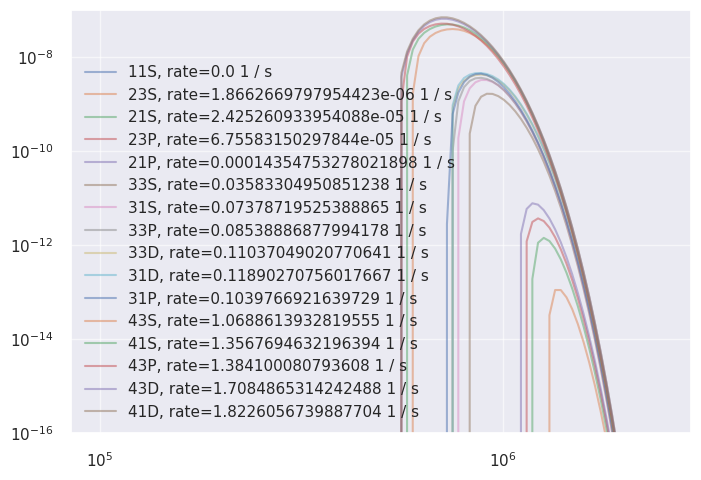

In [174]:
states = NLTE.NLTE_model.States.read_states(lambda table: (table["n"] <= 5))
v_range = np.geomspace(1e5, 2.5e6, 100) * u.m/u.s
for state in states.names:
    if state in sigma_params and state in ion_threshold:
        sigma = get_sigma(state, sigma_params, ion_threshold)
        integrand = lambda v: n_e * distibution(v) * v * sigma((1/2 * const.m_e * v**2).to("eV"))
        rate= np.trapz(integrand(v_range), v_range)
        plt.loglog(v_range, integrand(v_range), label=f"{state}, rate={rate.cgs}", alpha=0.5)

plt.ylim(1e-16, 1e-7)
plt.legend()
plt.show()

# Consistency check of electron collisions between Ralchenko and Kington

21.2180227112 eV
23.0870185296 eV
23.7420700688 eV
0.6022478882000009 eV
2.471243706600003 eV
3.1262952458000015 eV
1.7022946477999987 eV
1.8560520865699992 eV
2.455547878800001 eV
2.51831232416 eV
0.16670117060000322 eV
0.8217527098000019 eV
0.012943731830002747 eV
0.6629349243210001 eV
0.6679952710300014 eV
0.586552060399999 eV
0.6493165057599981 eV
0.06849947879999974 eV
0.000674686730999241 eV
0.005735033440000592 eV
1.144472364080002 eV
3.18745862071 eV
3.8882767029000007 eV
1.7543795299199978 eV
2.10956381946 eV
2.6298718239199985 eV
2.77200330102 eV
0.2886067267100003 eV
0.9894248089000008 eV
0.06657756283000182 eV
0.5868855672900004 eV
0.7290170443900017 eV
0.6633560984280003 eV
20.615774823 eV
22.920317359 eV
23.07407479777 eV
23.67357059 eV
23.73633503536 eV
23.737009722091 eV
1.868995818400002 eV
2.5189870108909993 eV
2.5240473576000007 eV
2.3045425359999996 eV
2.45829997477 eV
3.0577957670000018 eV
3.120560212360001 eV
3.121234899091 eV
0.5994957922300017 eV
0.6622602375900

/tmp/ipykernel_273054/1272326744.py:54: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(rate_matrix/mat, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap="seismic")
/tmp/ipykernel_273054/1272326744.py:54: RuntimeWarning: invalid value encountered in divide
  plt.imshow(rate_matrix/mat, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap="seismic")


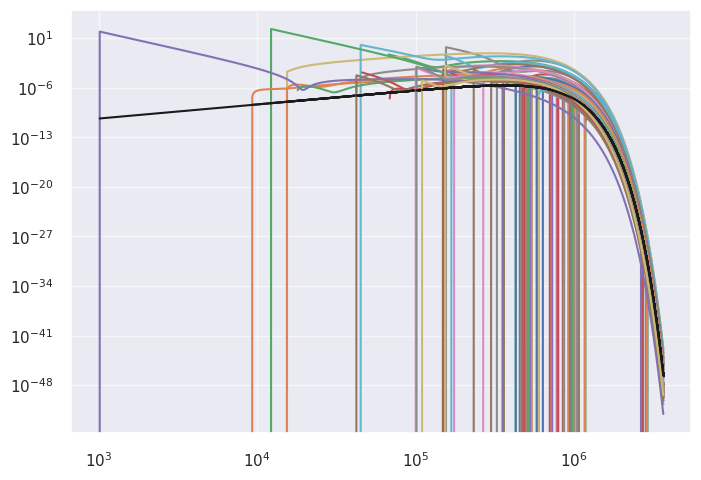

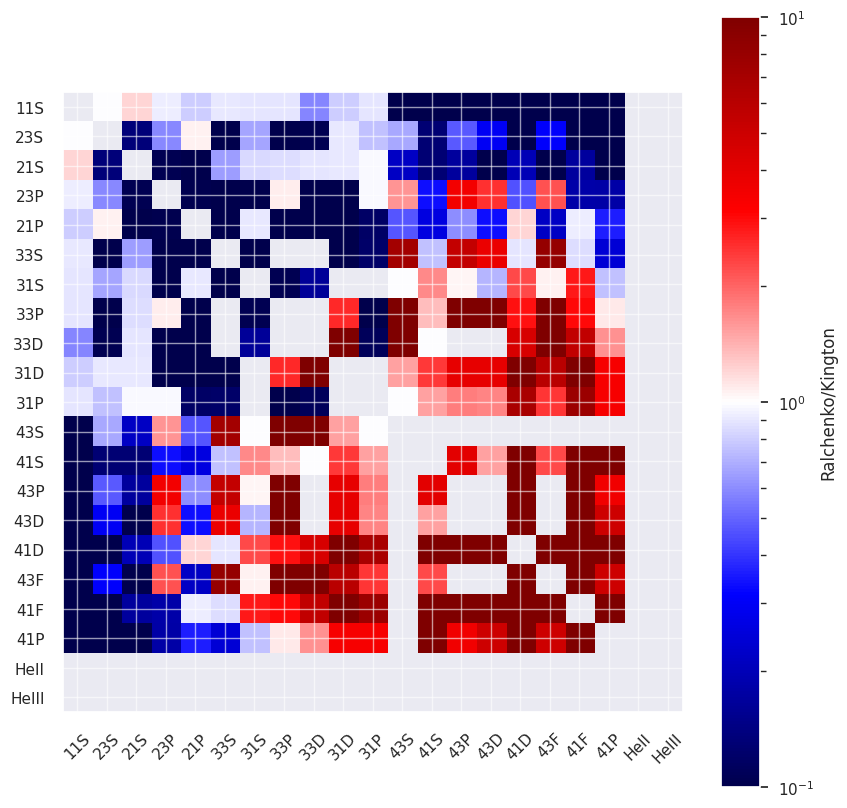

In [175]:
import functools
# use seaborn style
import seaborn as sns
sns.set_theme()

environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
states = NLTE.NLTE_model.States.read_states(lambda table: (table["n"] <= 4))
nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
get_E = lambda name: states.energies[states.names.index(name)]
get_g = lambda name: states.multiplicities[states.names.index(name)]

def get_cross_sections(filename, fit_function):
    table = pandas.read_csv(filename, skiprows=6, skipfooter=5, engine="python", sep="\s+", index_col=[0,1], header=None, skip_blank_lines=True)
    clamped_fit_function = lambda E, A, i, f: np.where(E>get_E(f) - get_E(i), fit_function(E/(get_E(f) - get_E(i)), A), 0) * np.pi * const.a0**2 * u.Ry / (get_g(i) * E)
    return {(i,f): functools.partial(clamped_fit_function, A=A, i = i, f=f) for (i,f), A in table.T.to_dict("list").items()}

sigmas = get_cross_sections("atomic data/dipole-allowed.csv",    lambda x, A: (A[0]*np.log(x) + A[1] + A[2]/x + A[3]/x**2 + A[4]/x**3)*(x+1)/(x+A[5]))\
       | get_cross_sections("atomic data/dipole-forbidden.csv", lambda x, A: (A[0] + A[1]/x + A[2]/x**2 + A[3]/x**3)*(x**2)/(x**2+A[4]))\
       | get_cross_sections("atomic data/spin-forbidden.csv",   lambda x, A: (A[0] + A[1]/x + A[2]/x**2 + A[3]/x**3)*(1)/(x**2+A[4]))

electron_v_distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))

v_to_E = lambda v: 1/2 * const.m_e * v**2
n_e = environment.n_e * u.cm**-3
T = environment.T_electrons * u.K
T_ev = T.to(u.eV, equivalencies=u.temperature_energy())
integrand = lambda v, sigma: n_e * electron_v_distibution(v) * v * sigma(v_to_E(v))

index = states.names
rate_matrix = np.zeros((len(states.all_names), len(states.all_names)))
for (lower,upper), sigma in sigmas.items(): 
    if lower not in states.names or upper not in states.names:
        continue
    # these are excitations rates:
    lower_index = states.names.index(lower)
    upper_index = states.names.index(upper)
    w_ratio =  get_g(lower) / get_g(upper)
    delta_E = get_E(upper) - get_E(lower)

    E_range = np.geomspace(delta_E.to(u.eV).value, T_ev.value*1e2, 10000) * u.eV
    v_range = np.sqrt(2*E_range/const.m_e)

    rate = np.trapz(integrand(v_range, sigma), v_range).to(1/u.s).value
    plt.loglog(v_range.si, integrand(v_range, sigma).si)
    rate_matrix[upper_index, lower_index] = rate
    # Calculate the deexcitation rate from f to i
    # Easier to come down if lower multiplicity is lower, and if the energy difference greater
    print(delta_E)
    rate_matrix[lower_index, upper_index] = rate * w_ratio * np.exp(delta_E/(const.k_B* T))
    plt.loglog(v_range.si, electron_v_distibution(v_range).si, color="k")
mat = nlte_solver.processes[0].get_transition_rate_matrix_Kingston()
plt.figure(figsize=(10,10))
# plot with log color scale
plt.imshow(rate_matrix/mat, norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1), cmap="seismic")
plt.colorbar(label="Ralchenko/Kington")
#plt.contour(rate_matrix/mat, levels=[1], colors="black")
plt.xticks(range(len(states.all_names)), states.all_names, rotation=45)
plt.yticks(range(len(states.all_names)), states.all_names);

In [169]:
rate_matrix

array([[0.00000000e+00, 2.97772664e-01, 5.26380302e-01, 2.24326498e-02,
        3.49710429e-02, 7.66719882e-02, 1.13831872e-01, 9.50113904e-03,
        1.19500276e-03, 1.14604711e-02, 8.40904061e-03, 2.55050436e-02,
        3.14630066e-02, 3.76913870e-03, 7.55196327e-04, 4.53056718e-03,
        3.77500555e-04, 6.85308002e-04, 3.95264752e-03, 0.00000000e+00,
        0.00000000e+00],
       [1.77638742e-23, 0.00000000e+00, 3.98650171e+01, 1.99599934e+01,
        3.48357262e+00, 1.03187380e+01, 4.34048852e+00, 2.57986887e+00,
        1.08995463e+00, 7.36338057e-01, 4.61384949e-01, 3.16115099e+00,
        1.82647295e+00, 7.36016214e-01, 2.74856260e-01, 2.42095566e-01,
        2.07564844e-01, 6.62422188e-02, 1.59044657e-01, 0.00000000e+00,
        0.00000000e+00],
       [1.28205289e-24, 1.62759147e+00, 0.00000000e+00, 2.36685252e+00,
        3.64409801e+01, 2.32865023e+00, 7.32288023e+00, 8.11356940e-01,
        2.14403754e-01, 2.08145879e+00, 1.23645084e+00, 1.01736984e+00,
        1.8047

In [170]:
T.to(u.eV, equivalencies=u.temperature_energy())

<Quantity 0.37916266 eV>

In [171]:

environment  = NLTE.NLTE_model.Environment(T_phot= T.value, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment, states = states)
states = NLTE.NLTE_model.States.read_states(lambda table: (table["n"] <= 4))
get_E = lambda name: states.energies[states.names.index(name)]
get_g = lambda name: states.multiplicities[states.names.index(name)]

def get_cross_sections(filename, fit_function):
    table = pandas.read_csv(filename, skiprows=6, skipfooter=5, engine="python", sep="\s+", index_col=[0,1], header=None, skip_blank_lines=True)
    clamped_fit_function = lambda E, A, i, f: np.where(E>get_E(f) - get_E(i), fit_function(E/(get_E(f) - get_E(i)), A), 0) * np.pi * const.a0**2 * u.Ry / (get_g(i) * E)
    return {(i,f): functools.partial(clamped_fit_function, A=A, i = i, f=f) for (i,f), A in table.T.to_dict("list").items()}

sigmas = get_cross_sections("atomic data/dipole-allowed.csv",    lambda x, A: (A[0]*np.log(x) + A[1] + A[2]/x + A[3]/x**2 + A[4]/x**3)*(x+1)/(x+A[5]))\
       | get_cross_sections("atomic data/dipole-forbidden.csv", lambda x, A: (A[0] + A[1]/x + A[2]/x**2 + A[3]/x**3)*(x**2)/(x**2+A[4]))\
       | get_cross_sections("atomic data/spin-forbidden.csv",   lambda x, A: (A[0] + A[1]/x + A[2]/x**2 + A[3]/x**3)*(1)/(x**2+A[4]))

electron_v_distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))
def quad_wrapper(func, a, b, **kwargs):
    in_unit = a.unit
    out_unit = func(a, *kwargs.get("args", tuple())).unit
    f = lambda x, *args: func(x*in_unit, *args).to(out_unit).value
    return scipy.integrate.quad(f, a.to(in_unit).value, b.to(in_unit).value, **kwargs, epsabs=1e-20) * out_unit * in_unit

v_to_E = lambda v: 1/2 * const.m_e * v**2
n_e = environment.n_e * u.cm**-3
T = environment.T_electrons * u.K
integrand = lambda v, sigma: n_e * electron_v_distibution(v) * v * sigma(v_to_E(v))

E_range = np.geomspace(1e-7, 1e5, 10000) * u.eV
v_range = np.sqrt(2*E_range/const.m_e)
index = states.names
rate_matrix = np.zeros((len(states.all_names), len(states.all_names)))
for (i,f), sigma in sigmas.items(): 
    if i not in states.names or f not in states.names:
        continue
    # these are excitations, so i is the lower state and f is the upper state
    # rate_matrix[i,f] on the other hand is the rate from f to i
    i_index = states.names.index(i)
    f_index = states.names.index(f)
    rate = np.trapz(integrand(v_range, sigma), v_range).to(1/u.s).value
    # Calculate the deexcitation rate from f to i
    # Easier to come down if lower multiplicity is lower, and if the energy difference greater
    w_ratio =  get_g(i) / get_g(f)
    delta_E = get_E(f) - get_E(i)
    rate_matrix[i_index, f_index] = rate * w_ratio * np.exp(delta_E/(const.k_B* T))
rate_matrix

array([[0.00000000e+00, 3.00390163e-01, 5.49914958e-01, 2.32468845e-02,
        3.45116221e-02, 8.31237960e-02, 1.07452983e-01, 9.53488311e-03,
        1.20660179e-03, 1.15921180e-02, 8.55407475e-03, 2.62029984e-02,
        3.33606037e-02, 3.70367526e-03, 7.74597568e-04, 4.76824035e-03,
        4.07024138e-04, 7.25471973e-04, 4.00856197e-03, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.98461517e+01, 1.99663989e+01,
        3.48060030e+00, 1.04213709e+01, 4.31944147e+00, 2.56744294e+00,
        1.09243563e+00, 7.41441133e-01, 4.60582819e-01, 3.15022192e+00,
        1.85749480e+00, 7.28647598e-01, 2.76198044e-01, 2.44579496e-01,
        2.09472504e-01, 6.68467709e-02, 1.58897567e-01, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.36571147e+00,
        3.64349469e+01, 2.34034777e+00, 7.36719288e+00, 8.08163219e-01,
        2.14078692e-01, 2.07695451e+00, 1.23218736e+00, 1.02368989e+00,
        1.7947

In [53]:
rate_matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.79200233e-23, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.33937394e-24, 1.62682124e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0000

In [29]:
states.all_names

['11S',
 '23S',
 '21S',
 '23P',
 '21P',
 '33S',
 '31S',
 '33P',
 '33D',
 '31D',
 '31P',
 '43S',
 '41S',
 '43P',
 '43D',
 '41D',
 '43F',
 '41F',
 '41P',
 '53S',
 '51S',
 '53P',
 '53D',
 '51D',
 '53F',
 '51F',
 '53G',
 '51G',
 '51P',
 'HeII',
 'HeIII']

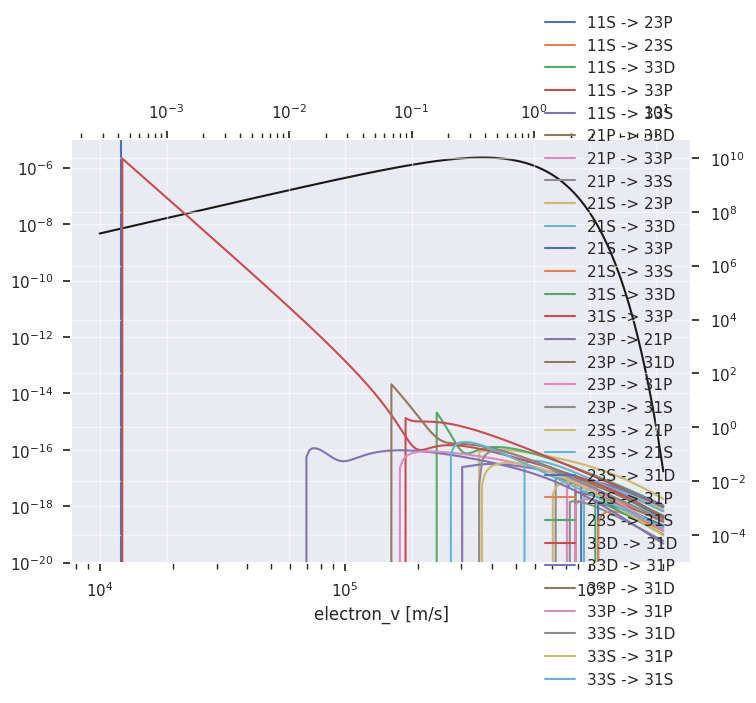

In [ ]:
T = 4400 * u.K
electron_v_distibution = lambda v: (const.m_e /(2*np.pi*const.k_B * T))**(3/2) * 4* np.pi * v**2 * np.exp(-const.m_e * v**2 /(2*const.k_B * T))
v_range = np.geomspace(1e4, 2e6, 200) * u.m/u.s
v_to_E = lambda v: 1/2 * const.m_e * v**2

plt.loglog(v_range, electron_v_distibution(v_range).si, color="k")
delta_E = np.abs(get_E("33D") - get_E("31D"))
v = np.sqrt(2*delta_E/const.m_e)
plt.axvline(v.si.value)
plt.ylim(1e-20,1e-5)
plt.xlabel("electron_v [m/s]")
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xscale("log")
ax2.set_xlim(*(v_to_E(np.array(ax1.get_xlim())*u.m/u.s)).to("eV").value)
ax3 = ax1.twinx()
for (i,f), sigma in sigmas.items(): 
    if (i[1] == "3") != (f[1] == "3") and i[0] in "123"  and f[0] in "123":
        ax3.loglog(v_range, sigma(v_to_E(v_range)), label=f"{i} -> {f}")
plt.legend(loc="right")